In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
import requests

import sys
sys.path.append("../01_crop_image")
from get_clean_image import *

200


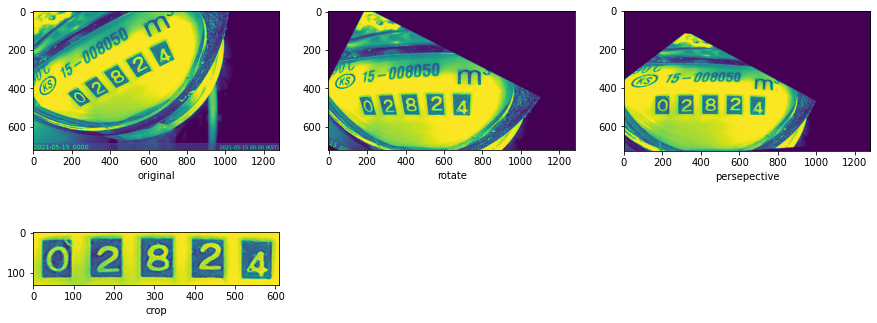

In [2]:
if __name__ == "__main__":
    img = []
    img.append(url_to_image('http://54.180.106.144:8080/websensor'))
    img.append(rotate_image(img[0]))
    img.append(fix_persepective(img[1]))
    img.append(crop_image(img[2]))

    label = ("original", "rotate", "persepective", "crop")
    plt.figure(figsize=(15,6))
    for i in range(4):
        plt.subplot(2,3,i+1)
        plt.imshow(img[i])
        plt.xlabel(label[i])
    plt.show()

    img4 = img[3]
    del img

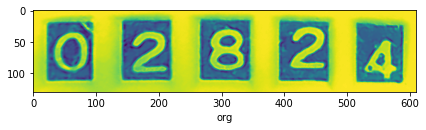

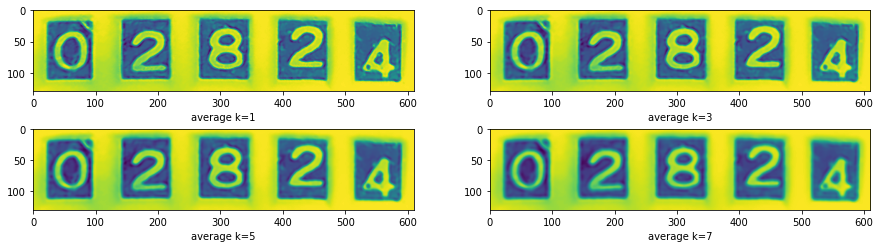

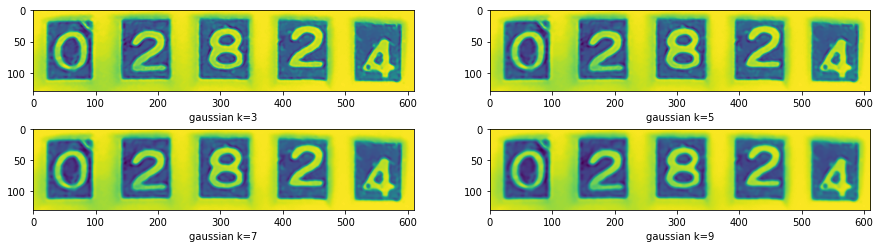

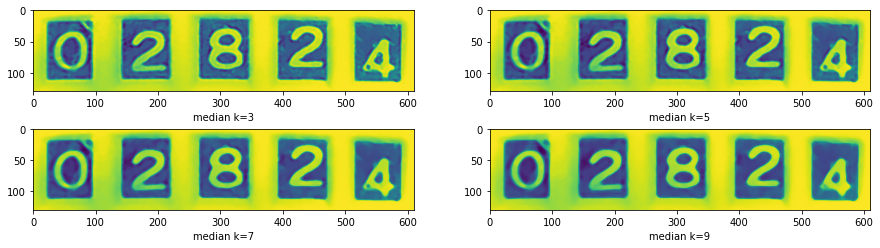

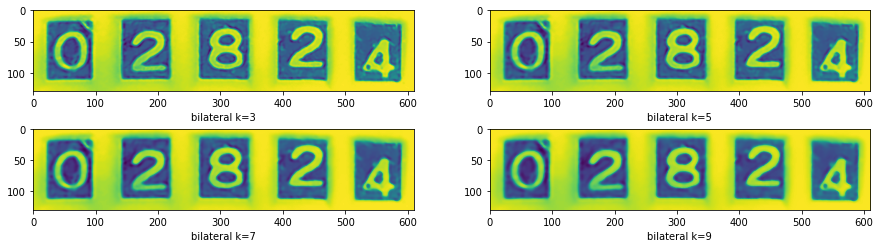

In [3]:
if __name__ == "__main__":
    plt.figure(figsize=(7,1.5))
    plt.imshow(img4)
    plt.xlabel("org")
    plt.show()

    plt.figure(figsize=(15,4))
    j=1
    for k in (1,3,5,7):
        img5 = cv2.blur(img4,(k,k))
        plt.subplot(2,2,j)
        plt.imshow(img5)
        plt.xlabel("average k=%d"%k)
        j += 1
    plt.show()

    plt.figure(figsize=(15,4))
    j = 1
    for k in (3,5,7,9):
        img5 = cv2.GaussianBlur(img4,(k,k),0)
        plt.subplot(2,2,j)
        plt.imshow(img5)
        plt.xlabel("gaussian k=%d"%(k))
        j += 1
    plt.show()

    plt.figure(figsize=(15,4))
    j = 1
    for k in (3,5,7,9):
        img5 = cv2.medianBlur(img4,k)
        plt.subplot(2,2,j)
        plt.imshow(img5)
        plt.xlabel("median k=%d"%(k))
        j += 1
    plt.show()

    plt.figure(figsize=(15,4))
    j = 1
    for k in (3,5,7,9):
        img5 = cv2.bilateralFilter(img4,k,75,75)
        plt.subplot(2,2,j)
        plt.imshow(img5)
        plt.xlabel("bilateral k=%d"%(k))
        j += 1
    plt.show()

    img5 = cv2.medianBlur(img4,9)

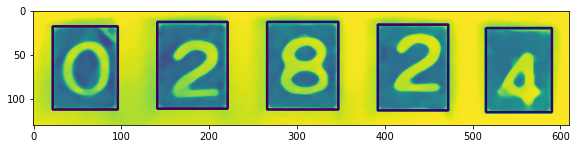

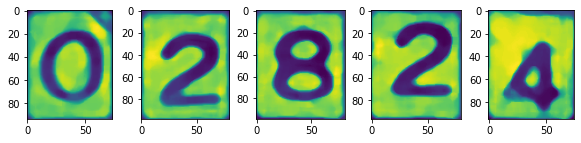

In [4]:
def merge(box1, box2):
    assert is_overlapping_horizontally(box1, box2)
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    x = min(x1, x2)
    w = max(x1 + w1, x2 + w2) - x
    y = min(y1, y2)
    h = max(y1 + h1, y2 + h2) - y
    return x, y, w, h

def is_overlapping_horizontally(box1, box2):
    x1, _, w1, _ = box1
    x2, _, _, _ = box2
    if x1 > x2:
        return is_overlapping_horizontally(box2, box1)
    return (x2 - x1) < w1

def to_contours_image(contours, ref_image):
    blank_background = np.zeros_like(ref_image)
    img_contours = cv2.drawContours(blank_background, contours, -1, (255, 255, 255), thickness=2)
    return img_contours

def filter_(contours):
    contours_dict = dict()
    for cont in contours:
        x, y, w, h = cv2.boundingRect(cont)
        area = cv2.contourArea(cont)
        if 10 < area and 10 < w and h > 5:
            contours_dict[(x, y, w, h)] = cont
    return sorted(contours_dict.values(), key=cv2.boundingRect)

def get_contours(img):
    # img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #edges = cv2.Canny(img, 20, 60)
    # print('edges:', edges)
    rimg = ~img
    ret, thr = cv2.threshold(rimg, 60, 150, 0)
    contours,_ = cv2.findContours(thr, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # images, contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_LIST)
    return filter_(contours)

def get_windows(contours):
    """return List[Tuple[x: Int, y: Int, w: Int, h: Int]]"""
    boxes = []
    for cont in contours:
        box = cv2.boundingRect(cont)
        if not boxes:
            boxes.append(box)
        else:
            if is_overlapping_horizontally(boxes[-1], box):
                last_box = boxes.pop()
                merged_box = merge(box, last_box)
                boxes.append(merged_box)
            else:
                boxes.append(box)
    return boxes

class OCRError(Exception):
    pass

def to_digit_images(img):
    contours = get_contours(img)
    image_contours = to_contours_image(contours, img)

    windows = get_windows(contours)
    img2 = img.copy()
    for box in windows:
        x, y, w, h = box
        img2 = cv2.rectangle(img2, (x, y), (x + w, y + h), (0, 255, 0), 2)
    if __name__ == "__main__":
        plt.figure(figsize=(11,2.1))
        plt.imshow(img2)
        plt.show()
    
    if len(windows) != 5:
        raise OCRError
        return []
    else:
        xs = [image_contours[y:y+h, x:x+w] for (x, y, w, h) in windows]
        xs = [img[y:y+h, x:x+w] for (x, y, w, h) in windows]
        return xs

if __name__ == "__main__":
    rois = to_digit_images(img5)
    plt.figure(figsize=(10,2))
    for i, digit_img in enumerate(rois):
        rd = ~digit_img
        plt.subplot(1,5,i+1)
        plt.imshow(rd)
    plt.show()